<a href="https://colab.research.google.com/github/Adhyatik/MLM-PROJECT-REPORT/blob/main/Group6_FAAD_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment on Fraud Analytics and Anomaly Detection**

In [1]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Step 1: Install the required library
!pip install gdown

In [4]:
# Step 3: Read the CSV file into a DataFrame
import pandas as pd
df = pd.read_csv('/content/UNSW_NB15_traintest_backdoor.csv')
# Step 4: Display a sample of the DataFrame
print(df.sample(5))

            dur  proto=udp  proto=arp  proto=tcp  proto=igmp  proto=ospf  \
92010  0.021864          0          0          1           0           0   
30492  0.000000          0          0          1           0           0   
10737  0.000017          1          0          0           0           0   
42698  0.000083          0          0          1           0           0   
91040  0.014783          0          0          1           0           0   

       proto=sctp  proto=gre  proto=ggp  proto=ip  ...  ct_src_dport_ltm  \
92010           0          0          0         0  ...               0.0   
30492           0          0          0         0  ...               0.0   
10737           0          0          0         0  ...               0.0   
42698           0          0          0         0  ...               0.0   
91040           0          0          0         0  ...               0.0   

       ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
92010            

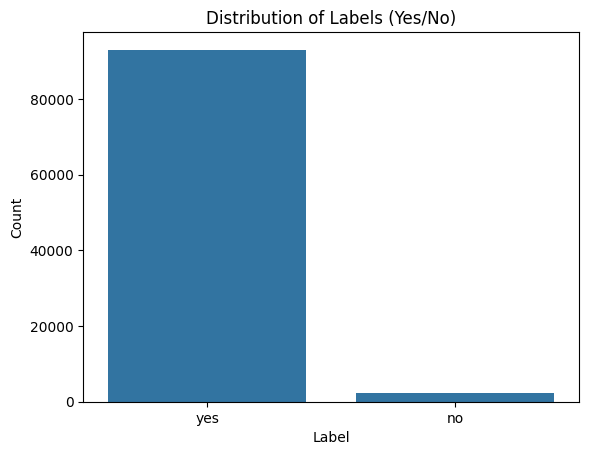

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'class' is the last column name (if not, replace with the actual name)
# Re-read the original dataframe to avoid issues from previous cell execution
df = pd.read_csv('/content/UNSW_NB15_traintest_backdoor.csv')
class_column_name = df.columns[-1]

# Fill missing values in 'class' column with the mode (most frequent value)
# Check if the column has any values before calculating the mode
if not df[class_column_name].empty:
    df[class_column_name] = df[class_column_name].fillna(df[class_column_name].mode()[0])

# Create a new column 'attack_cat' with 'yes' and 'no' based on 'class'
df['attack_cat'] = df[class_column_name].map({0: 'yes', 1: 'no'})

# Drop rows with values other than 0 and 1 in the 'class' column
df = df[df[class_column_name].isin([0, 1])]

# Create a new figure before plotting
plt.figure()
sns.countplot(x='attack_cat', data=df)
plt.title('Distribution of Labels (Yes/No)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

**COUNT OF MISSING VALUES**

In [6]:
missing_values = df.isnull().sum()
print(missing_values)
missing_percentage = (missing_values / len(df)) * 100
missing_percentage

dur                0
proto=udp          0
proto=arp          0
proto=tcp          0
proto=igmp         0
                  ..
ct_src_ltm         0
ct_srv_dst         0
is_sm_ips_ports    0
class              0
attack_cat         0
Length: 198, dtype: int64


,0
dur,0.0
proto=udp,0.0
proto=arp,0.0
proto=tcp,0.0
proto=igmp,0.0
...,...
ct_src_ltm,0.0
ct_srv_dst,0.0
is_sm_ips_ports,0.0
class,0.0


In [7]:
df.shape

(95329, 198)

**## Feature selection: Top 10 Features are selected on the basis of the random Forest**

In [8]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Assuming 'df' is your DataFrame and has both features and target columns.
# If your target column is named 'class', separate it from features
X = df.drop(columns=['attack_cat'])  # Drop target column
y = df['attack_cat']  # Target column
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
# Sort the features by importance
feature_names = X.columns
important_features = pd.Series(importances, index=feature_names).sort_values(ascending=False)
important_features

,0
class,0.374038
proto=udp,0.084380
ct_dst_sport_ltm,0.068876
sbytes,0.058804
proto=unas,0.053415
...,...
proto=ib,0.000000
service=ssl,0.000000
service=dhcp,0.000000
state=ACC,0.000000


In [9]:
# Get the top 10 feature names
top_10_features = important_features.head(10).index.tolist()

# Print the names
top_10_features

['class',
 'proto=udp',
 'ct_dst_sport_ltm',
 'sbytes',
 'proto=unas',
 'sload',
 'smean',
 'spkts',
 'sttl',
 'rate']

In [10]:
# Select top N features (for example, top 10)
selected_features = important_features.head(10).index
print("Selected Features:", selected_features)

Selected Features: Index(['class', 'proto=udp', 'ct_dst_sport_ltm', 'sbytes', 'proto=unas',
       'sload', 'smean', 'spkts', 'sttl', 'rate'],
      dtype='object')


The Selected Features are:-"'class',
 'ct_dst_sport_ltm',
 'proto=unas',
 'proto=udp',
 'sbytes',
 'smean',
 'ct_srv_dst',
 'sload',
 'ct_srv_src',
 'ct_src_dport_ltm'"

In [11]:
# X_selected = X[selected_features]

X_selected = X[selected_features]

**# SMOTE Sampling**

In [12]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE on the entire dataset before splitting
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_selected, y)

# Check the class distribution after SMOTE
print("SMOTE Class Distribution:\n", pd.Series(y_smote).value_counts())

# Print a sample of the resampled dataset
smote_sample = pd.concat([X_smote, y_smote], axis=1)
print("\nSMOTE Resampled Dataset Sample:\n", smote_sample.head())

SMOTE Class Distribution:
 attack_cat
yes    93000
no     93000
Name: count, dtype: int64

SMOTE Resampled Dataset Sample:
    class  proto=udp  ct_dst_sport_ltm    sbytes  proto=unas     sload  \
0      0          1               0.0  0.001397           0  0.033751   
1      0          1               0.0  0.005123           0  0.164858   
2      0          1               0.0  0.003091           0  0.159880   
3      0          1               0.0  0.002583           0  0.112275   
4      0          1               0.0  0.006181           0  0.159131   

      smean     spkts      sttl      rate attack_cat  
0  0.149456  0.001452  0.996078  0.090909        yes  
1  0.579484  0.001452  0.996078  0.125000        yes  
2  0.343750  0.001452  0.996078  0.200000        yes  
3  0.286685  0.001452  0.996078  0.166667        yes  
4  0.703125  0.001452  0.996078  0.100000        yes  


**DOWNSAMPLING**

In [13]:
from imblearn.under_sampling import RandomUnderSampler

# Apply downsampling on the entire dataset before splitting
down_sampler = RandomUnderSampler(random_state=42)
X_down, y_down = down_sampler.fit_resample(X_selected, y)

# Check the class distribution after downsampling
print("Downsampled Class Distribution:\n", pd.Series(y_down).value_counts())

# Print a sample of the resampled dataset
down_sample = pd.concat([X_down, y_down], axis=1)
print("\nDownsampled Resampled Dataset Sample:\n", down_sample.head())

Downsampled Class Distribution:
 attack_cat
no     2329
yes    2329
Name: count, dtype: int64

Downsampled Resampled Dataset Sample:
      class  proto=udp  ct_dst_sport_ltm    sbytes  proto=unas     sload  \
243      1          0          0.000000  0.003683           0  0.000002   
244      1          0          0.200000  0.000508           0  0.049901   
245      1          0          0.000000  0.003006           0  0.000003   
246      1          0          0.022222  0.000508           0  0.016634   
247      1          0          0.000000  0.001270           0  0.000002   

        smean     spkts      sttl      rate attack_cat  
243  0.024456  0.027578  0.996078  0.000021         no  
244  0.048912  0.001452  0.996078  0.333333         no  
245  0.016304  0.027578  0.996078  0.000039         no  
246  0.048912  0.001452  0.996078  0.111111         no  
247  0.011548  0.013055  0.996078  0.000071         no  


**UPSAMPLING**

In [14]:
from imblearn.over_sampling import RandomOverSampler
# Apply upsampling on the entire dataset before splitting
up_sampler = RandomOverSampler(random_state=42)
X_up, y_up = up_sampler.fit_resample(X_selected, y)
# Check the class distribution after upsampling
print("Upsampled Class Distribution:", pd.Series(y_up).value_counts())
# Print a sample of the resampled dataset
up_sample = pd.concat([X_up, y_up], axis=1)
print("Upsampled Resampled Dataset Sample:\n", up_sample.head())

Upsampled Class Distribution: attack_cat
yes    93000
no     93000
Name: count, dtype: int64
Upsampled Resampled Dataset Sample:
    class  proto=udp  ct_dst_sport_ltm    sbytes  proto=unas     sload  \
0      0          1               0.0  0.001397           0  0.033751   
1      0          1               0.0  0.005123           0  0.164858   
2      0          1               0.0  0.003091           0  0.159880   
3      0          1               0.0  0.002583           0  0.112275   
4      0          1               0.0  0.006181           0  0.159131   

      smean     spkts      sttl      rate attack_cat  
0  0.149456  0.001452  0.996078  0.090909        yes  
1  0.579484  0.001452  0.996078  0.125000        yes  
2  0.343750  0.001452  0.996078  0.200000        yes  
3  0.286685  0.001452  0.996078  0.166667        yes  
4  0.703125  0.001452  0.996078  0.100000        yes  


**ISOLATION FOREST**

In [15]:
from sklearn.ensemble import IsolationForest

anomaly_inputs = ['ct_dst_sport_ltm', 'proto=unas', 'proto=udp', 'sbytes', 'smean', 'ct_srv_dst', 'sload', 'ct_srv_src', 'ct_src_dport_ltm', 'class']

model_IF = IsolationForest(contamination=0.1, random_state=42)

# **Isolation Forest applied on Original Datset**

In [16]:
model_IF.fit(df[anomaly_inputs])
df['anomaly_scores'] = model_IF.decision_function(df[anomaly_inputs])
df['anomaly'] = model_IF.predict(df[anomaly_inputs])
df.loc[:, ['ct_dst_sport_ltm', 'proto=unas', 'proto=udp', 'sbytes', 'smean', 'ct_srv_dst', 'sload', 'ct_srv_src', 'ct_src_dport_ltm', 'class', 'anomaly_scores', 'anomaly']]

,ct_dst_sport_ltm,proto=unas,proto=udp,sbytes,smean,ct_srv_dst,sload,ct_srv_src,ct_src_dport_ltm,class,anomaly_scores,anomaly
0,0.0,0,1,0.001397,0.149456,0.016393,0.033751,0.016129,0.000000,0,0.014966,1
1,0.0,0,1,0.005123,0.579484,0.016393,0.164858,0.016129,0.000000,0,-0.120368,-1
2,0.0,0,1,0.003091,0.343750,0.032787,0.159880,0.032258,0.000000,0,-0.076648,-1
3,0.0,0,1,0.002583,0.286685,0.032787,0.112275,0.032258,0.022222,0,-0.044916,-1
4,0.0,0,1,0.006181,0.703125,0.032787,0.159131,0.032258,0.022222,0,-0.151937,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
95324,0.0,0,0,0.001312,0.012908,0.000000,0.000000,0.000000,0.000000,1,-0.033916,-1
95325,0.0,0,1,0.000593,0.019701,0.000000,0.000004,0.000000,0.000000,1,-0.037618,-1
95326,0.0,0,0,0.018967,0.137908,0.000000,0.000004,0.016129,0.000000,1,-0.044939,-1
95327,0.0,0,0,0.001312,0.012908,0.000000,0.000001,0.000000,0.000000,1,-0.033916,-1


Outlier Method: Isolation Forest
Number of anomalous values: 9533
Number of non-anomalous values: 85796
Total number of values: 95329
Percentage of anomalous values: 10.00%


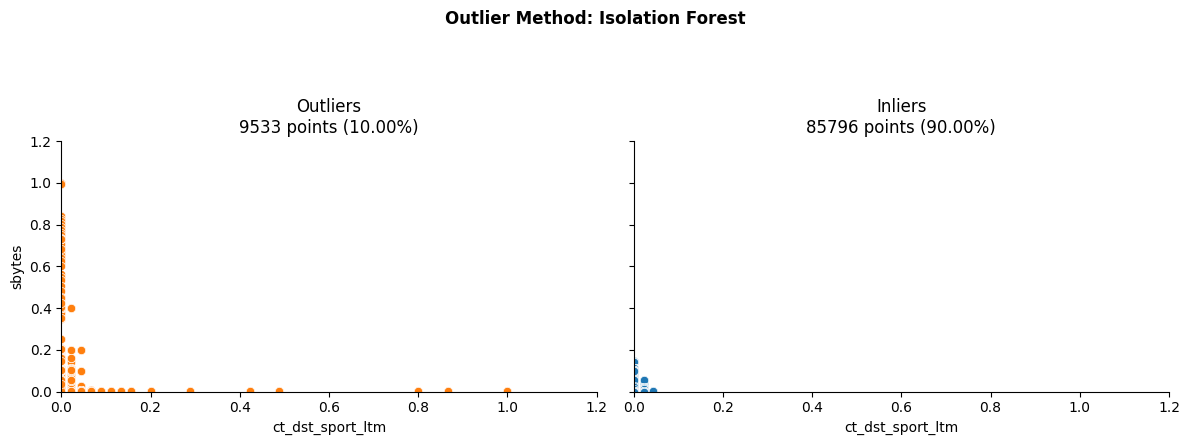

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt # This should be outside the function

def outlier_plot(data, outlier_method_name, x_var, y_var,
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):
    print(f'Outlier Method: {outlier_method_name}')
    # Compute anomaly counts
    num_anomalies = len(data[data['anomaly'] == -1])
    num_inliers = len(data[data['anomaly'] == 1])
    total_values = len(data)
    # Calculate anomaly percentage
    anomaly_percentage = (num_anomalies / total_values) * 100
    print(f"Number of anomalous values: {num_anomalies}")
    print(f"Number of non-anomalous values: {num_inliers}")
    print(f"Total number of values: {total_values}")
    print(f"Percentage of anomalous values: {anomaly_percentage:.2f}%")
    # Create FacetGrid plot
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1, -1], aspect=1.5) # Added aspect for better visualization
    g.map(sns.scatterplot, x_var, y_var)
    # Customize plot title and axes
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)  # Use provided limits if specified
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{num_anomalies} points ({anomaly_percentage:.2f}%)")
    axes[1].set_title(f"Inliers\n{num_inliers} points ({100 - anomaly_percentage:.2f}%)")
    plt.tight_layout() # Improves spacing between subplots
    plt.show() # To display the plot
    return g

outlier_plot(df, 'Isolation Forest', 'ct_dst_sport_ltm', 'sbytes', [0, df['ct_dst_sport_ltm'].max() * 1.2], [0, df['sbytes'].max() * 1.2]); #Passing x and y limits for dynamic scaling

# **Isolation Forest on SMOTE**

Outlier Method: Isolation Forest
Number of anomalous values: 18392
Number of non-anomalous values: 167608
Total number of values: 186000
Percentage of anomalous values: 9.89%


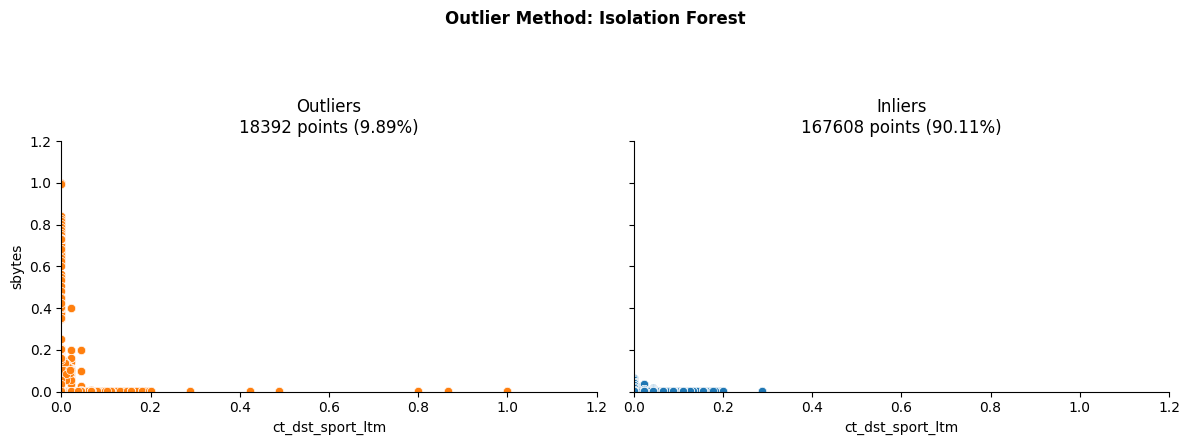

In [19]:
# Instead of:
# anomaly_inputs = ['ct_dst_sport_ltm', 'proto=unas', 'proto=udp', 'sbytes', 'smean', 'ct_srv_dst', 'sload', 'ct_srv_src', 'ct_src_dport_ltm', 'class']

# Get the column names from smote_sample
anomaly_inputs = smote_sample.columns.tolist()

# Remove 'attack_cat', 'anomaly_scores', and 'anomaly' if they exist
anomaly_inputs = [col for col in anomaly_inputs if col not in ['attack_cat', 'anomaly_scores', 'anomaly']]

# Now use the updated anomaly_inputs:
model_IF.fit(smote_sample[anomaly_inputs])
smote_sample['anomaly_scores'] = model_IF.decision_function(smote_sample[anomaly_inputs])
smote_sample['anomaly'] = model_IF.predict(smote_sample[anomaly_inputs])
outlier_plot(smote_sample, 'Isolation Forest', 'ct_dst_sport_ltm', 'sbytes', [0, smote_sample['ct_dst_sport_ltm'].max() * 1.2], [0, smote_sample['sbytes'].max() * 1.2]);

# **Isolation Forest on UPSAMPLE**

Outlier Method: Isolation Forest
Number of anomalous values: 18102
Number of non-anomalous values: 167898
Total number of values: 186000
Percentage of anomalous values: 9.73%


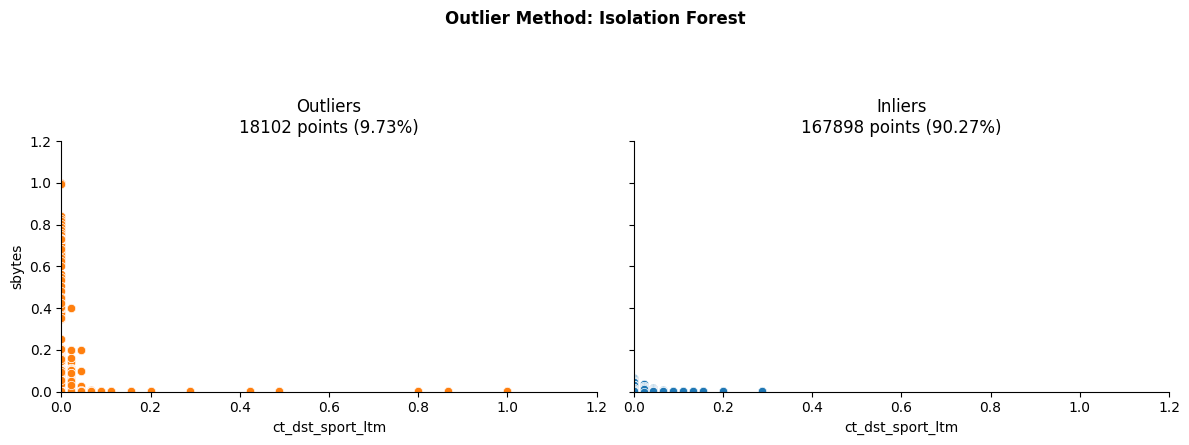

In [20]:
model_IF.fit(up_sample[anomaly_inputs])
up_sample['anomaly_scores'] = model_IF.decision_function(up_sample[anomaly_inputs])
up_sample['anomaly'] = model_IF.predict(up_sample[anomaly_inputs])
outlier_plot(up_sample, 'Isolation Forest', 'ct_dst_sport_ltm', 'sbytes', [0, up_sample['ct_dst_sport_ltm'].max() * 1.2], [0, up_sample['sbytes'].max() * 1.2]);



# **Isolation Forest on Downsample**

Outlier Method: Isolation Forest
Number of anomalous values: 466
Number of non-anomalous values: 4192
Total number of values: 4658
Percentage of anomalous values: 10.00%


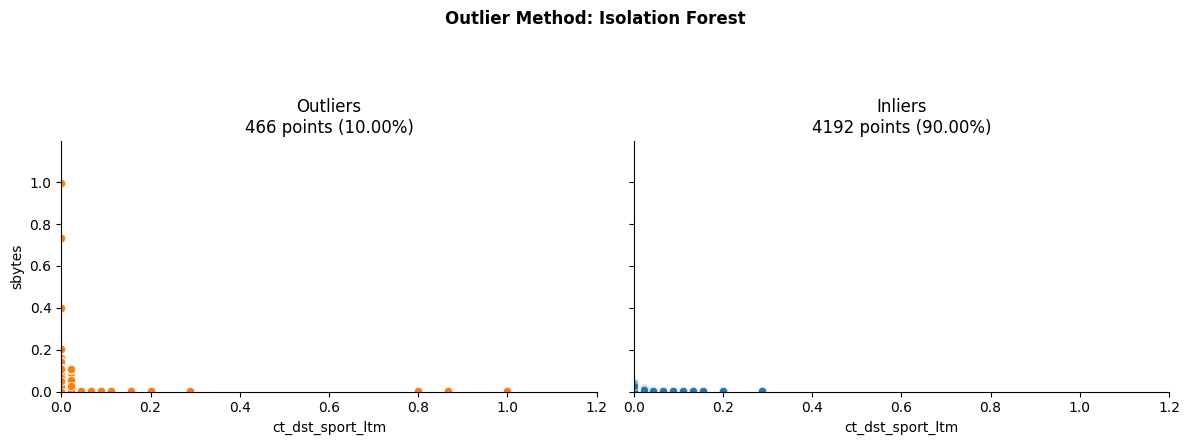

In [21]:
model_IF.fit(down_sample[anomaly_inputs])
down_sample['anomaly_scores'] = model_IF.decision_function(down_sample[anomaly_inputs])
down_sample['anomaly'] = model_IF.predict(down_sample[anomaly_inputs])
outlier_plot(down_sample, 'Isolation Forest', 'ct_dst_sport_ltm', 'sbytes', [0, down_sample['ct_dst_sport_ltm'].max() * 1.2], [0, down_sample['sbytes'].max() * 1.2]);

# **Splitting**

## **Splitting the SMOTE Dataset**

In [22]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.25, random_state=42, stratify=y_smote)

## **Splitting the Downsampled Dataset**


In [23]:
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X_down, y_down, test_size=0.25, random_state=42, stratify=y_down)

## **Splitting the Upsampled Dataset**


In [24]:
# Split the upsampled dataset
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size=0.25, random_state=42)

**ANN**

In [25]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# Assuming X_train_smote contains string columns, you need to convert them to numerical
# Replace 'string_column_name1', 'string_column_name2' etc. with the actual names
# of your string columns in X_train_smote
for column in X_train_smote.select_dtypes(include=['object']).columns:
    X_train_smote[column] = pd.factorize(X_train_smote[column])[0]

# Ensure y_train_smote is also numerical (0 and 1) if it's not already:
y_train_smote = pd.factorize(y_train_smote)[0]

model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(X_train_smote.shape[1],), activation='relu'), # Adjusted input_shape
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_smote, y_train_smote, epochs=100)

Epoch 1/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9635 - loss: 0.0885
Epoch 2/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 8.1564e-06
Epoch 3/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 5.8076e-07
Epoch 4/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 1.0000 - loss: 5.3204e-08
Epoch 5/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 8.0834e-09
Epoch 6/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 4.3563e-09
Epoch 7/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 1.0000 - loss: 4.0716e-09
Epoch 8/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 3.7765e-09
Epoch 9/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 1.0000 - loss: 3.6965e-09
Epoch 10/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 1.0000 - loss: 3.7328e-09
Epoch 11/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 

In [26]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

# ... (your existing code) ...

# Before evaluating the model, preprocess X_test_smote:
for column in X_test_smote.select_dtypes(include=['object']).columns:
    X_test_smote[column] = pd.factorize(X_test_smote[column])[0]

# Ensure y_test_smote is also numerical (0 and 1) if it's not already:
y_test_smote = pd.factorize(y_test_smote)[0] # Applying the same preprocessing for y_test_smote

# Now evaluate the model:
model.evaluate(X_test_smote, y_test_smote)

1454/1454 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.0000e+00 - loss: 25.9549


[26.010709762573242, 0.0]

In [27]:
yp = model.predict(X_test_smote)
yp = (yp > 0.5).astype(int) # Convert probabilities to binary predictions
yp[:5]

1454/1454 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


array([[1],
       [0],
       [0],
       [1],
       [0]])

In [28]:
y_pred_smote = yp.flatten().astype(int)

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test_smote, y_pred_smote))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00   23250.0
           1       0.00      0.00      0.00   23250.0

    accuracy                           0.00   46500.0
   macro avg       0.00      0.00      0.00   46500.0
weighted avg       0.00      0.00      0.00   46500.0



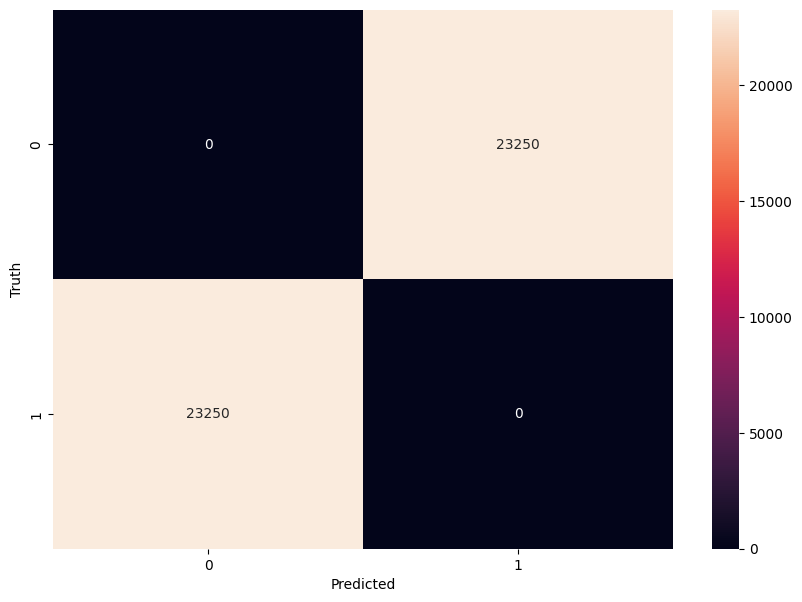

In [30]:
import seaborn as sns
cm = confusion_matrix(y_test_smote, y_pred_smote)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## **ANN on SMOTE**

In [31]:
model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(X_train_smote.shape[1],), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_smote, y_train_smote, epochs=100)

Epoch 1/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9959 - loss: 0.0703
Epoch 2/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 1.0000 - loss: 1.8591e-06
Epoch 3/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 1.0000 - loss: 1.2579e-07
Epoch 4/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 1.0000 - loss: 1.5194e-08
Epoch 5/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 5.5181e-09
Epoch 6/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 1.0000 - loss: 4.5824e-09
Epoch 7/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 4.0811e-09
Epoch 8/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 3.8195e-09
Epoch 9/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 1.0000 - loss: 3.6183e-09
Epoch 10/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 1.0000 - loss: 3.5554e-09
Epoch 11/100
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accura

In [32]:
model.evaluate(X_test_smote, y_test_smote)

1454/1454 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0000e+00 - loss: 25.6469


[25.698530197143555, 0.0]

In [33]:
yp = model.predict(X_test_smote)
yp[:5]

1454/1454 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


array([[1.0000000e+00],
       [3.8859084e-16],
       [6.7748834e-13],
       [1.0000000e+00],
       [9.8182977e-16]], dtype=float32)

In [34]:
y_pred_smote = []
for element in yp:
    if element > 0.5:
        y_pred_smote.append(1)
    else:
        y_pred_smote.append(0)

In [35]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test_smote,y_pred_smote))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00   23250.0
           1       0.00      0.00      0.00   23250.0

    accuracy                           0.00   46500.0
   macro avg       0.00      0.00      0.00   46500.0
weighted avg       0.00      0.00      0.00   46500.0



Text(95.72222222222221, 0.5, 'Truth')

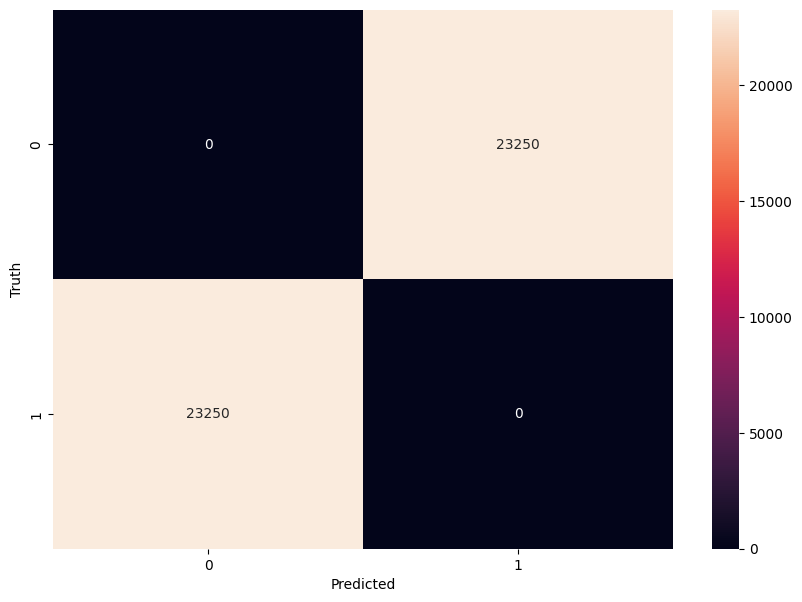

In [37]:
cm = tf.math.confusion_matrix(labels=y_test_smote,predictions=y_pred_smote)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d') # Changed sn to sns
plt.xlabel('Predicted')
plt.ylabel('Truth')

## **ANN on UPSAMPLE**

In [39]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Assuming X_train_up contains string columns, you need to convert them to numerical
# Replace 'string_column_name1', 'string_column_name2' etc. with the actual names
# of your string columns in X_train_up
for column in X_train_up.select_dtypes(include=['object']).columns:
    X_train_up[column] = pd.factorize(X_train_up[column])[0]

# Assuming y_train_up contains string labels like 'yes' and 'no', convert them to numerical
y_train_up = pd.factorize(y_train_up)[0]

model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(X_train_up.shape[1],), activation='relu'), # Adjusted input_shape
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_up, y_train_up, epochs=10)

Epoch 1/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9926 - loss: 0.0553
Epoch 2/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 1.0000 - loss: 1.0155e-05
Epoch 3/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 1.0000 - loss: 7.0798e-07
Epoch 4/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 1.0000 - loss: 6.2045e-08
Epoch 5/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 1.0000 - loss: 6.6325e-09
Epoch 6/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 1.1870e-09
Epoch 7/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 1.0000 - loss: 5.1577e-10
Epoch 8/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 1.0000 - loss: 4.5049e-10
Epoch 9/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 4.2917e-10
Epoch 10/10
4360/4360 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 1.0000 - loss: 4.2020e-10


In [41]:
import pandas as pd

# Preprocess X_test_up to convert string columns to numerical
for column in X_test_up.select_dtypes(include=['object']).columns:
    X_test_up[column] = pd.factorize(X_test_up[column])[0]

# Preprocess y_test_up to convert string labels to numerical
y_test_up = pd.factorize(y_test_up)[0]

# Now evaluate the model:
model.evaluate(X_test_up, y_test_up)

1454/1454 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 4.2955e-10


[4.3650669190320457e-10, 1.0]

In [42]:
yp = model.predict(X_test_up)
yp[:5]

1454/1454 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


array([[4.3633972e-12],
       [1.3606701e-12],
       [1.3603639e-12],
       [1.0000000e+00],
       [4.7172552e-12]], dtype=float32)

In [43]:
y_pred_up = []
for element in yp:
    if element > 0.5:
        y_pred_up.append(1)
    else:
        y_pred_up.append(0)

In [44]:
print(classification_report(y_test_up,y_pred_up))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23240
           1       1.00      1.00      1.00     23260

    accuracy                           1.00     46500
   macro avg       1.00      1.00      1.00     46500
weighted avg       1.00      1.00      1.00     46500



Text(95.72222222222221, 0.5, 'Truth')

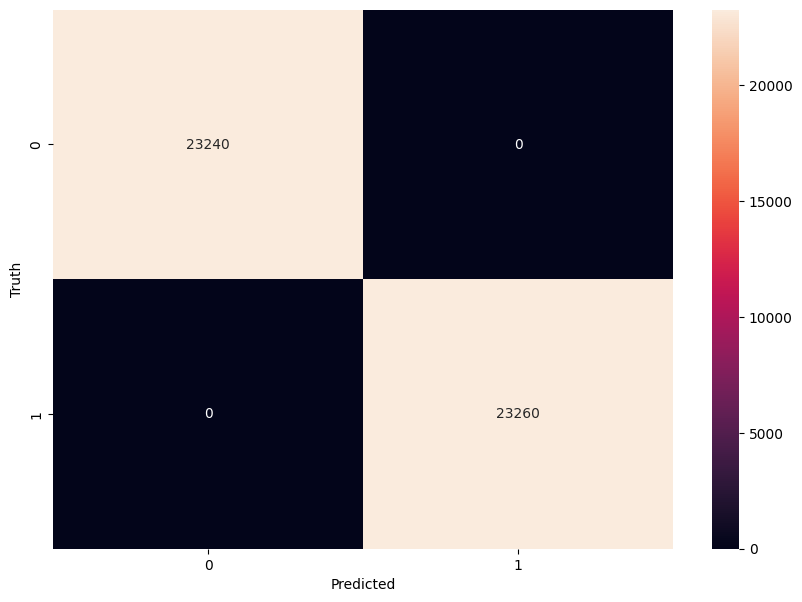

In [46]:
cm = tf.math.confusion_matrix(labels=y_test_up,predictions=y_pred_up)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d') # Changed sn to sns
plt.xlabel('Predicted')
plt.ylabel('Truth')

# **ANN on DOWNSAMPLE**

In [48]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Convert string columns in X_train_down to numerical using factorize
for column in X_train_down.select_dtypes(include=['object']).columns:
    X_train_down[column] = pd.factorize(X_train_down[column])[0]

# Ensure y_train_down is also numerical (0 and 1)
y_train_down = pd.factorize(y_train_down)[0]

# Define and compile the model (rest of your code remains the same)
model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(X_train_down.shape[1],), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Now fit the model
model.fit(X_train_down, y_train_down, epochs=10)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7972 - loss: 0.6415
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.2553
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0531
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0145
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0055
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0011
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.7214e-04
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 1.0000 - loss: 5.7759e-04


In [50]:
# Preprocess X_test_down similar to X_train_down
for column in X_test_down.select_dtypes(include=['object']).columns:
    X_test_down[column] = pd.factorize(X_test_down[column])[0]

# Preprocess y_test_down to convert string labels to numerical using the same factorize mapping as y_train_down
y_test_down = pd.factorize(y_test_down)[0]

# Evaluate the model
model.evaluate(X_test_down, y_test_down)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 8.1775


[8.197321891784668, 0.0]

In [51]:
yp = model.predict(X_test_down)
yp[:5]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[9.9995363e-01],
       [1.6009111e-05],
       [9.9897414e-01],
       [9.9937069e-01],
       [9.9944144e-01]], dtype=float32)

In [52]:
y_pred_down = []
for element in yp:
    if element > 0.5:
        y_pred_down.append(1)
    else:
        y_pred_down.append(0)

In [53]:
print(classification_report(y_test_down,y_pred_down))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     582.0
           1       0.00      0.00      0.00     583.0

    accuracy                           0.00    1165.0
   macro avg       0.00      0.00      0.00    1165.0
weighted avg       0.00      0.00      0.00    1165.0



Text(95.72222222222221, 0.5, 'Truth')

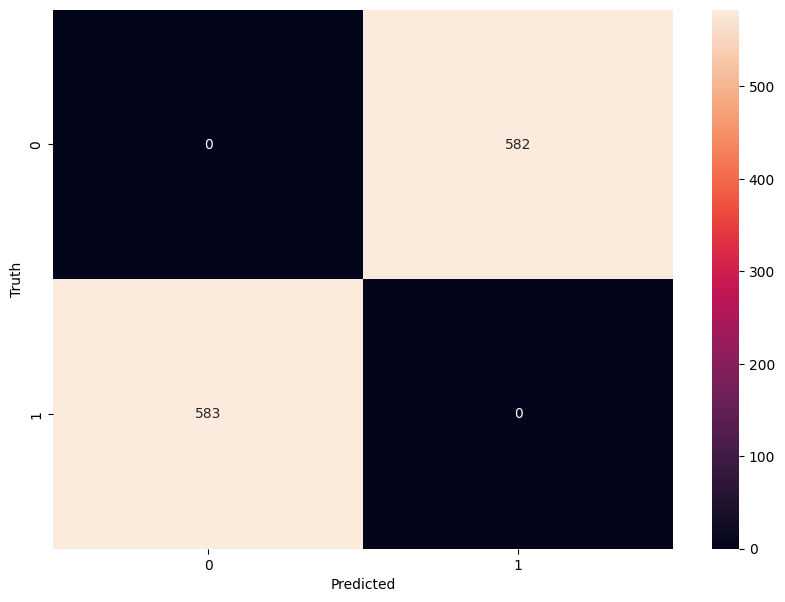

In [55]:
cm = tf.math.confusion_matrix(labels=y_test_down,predictions=y_pred_down)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')